In [14]:
import pandas as pd
import numpy as np
import json
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

import matplotlib.pyplot as plt
%matplotlib inline
import molplotly
import plotly.express as px

from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, precision_score, r2_score, precision_recall_curve, roc_auc_score, average_precision_score, precision_score, recall_score, \
ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, f1_score, accuracy_score, matthews_corrcoef, mean_squared_log_error, mean_absolute_percentage_error, roc_curve

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

import constants as co

METHOD_PREFIX = "xgboost"
RESULT_FILE_REGRESSOR = "result_regressor_xgboost.csv"
RESULT_FILE_CLASSIFIER = "result_classifier_xgboost.csv"

DEBUG:Loaded backend module://matplotlib_inline.backend_inline version unknown.


# Raw approach, all data

In [27]:
df_actual_pred = pd.read_csv("C:/Users/rbachorz/Projects/qsarmodeler/qsarmodeler/data/processed/ar/regressor_validation_actual_predicted.csv", index_col="Unnamed: 0")
df_actual_pred

,coms_canonical_smiles,experimental_value,predicted_value
894,[C-]#[N+]c1ccc(N2C(=O)C3(CCC3)N(c3ccc(CCCC(=O)...,7.036212,5.865554
1140,CC1(C)NC(=O)N(c2ccnc3ccccc23)C1=O,5.886057,5.859020
339,C[C@]12CCC(=O)C=C1C[C@@H](CCCc1ccc(OCCC(=O)O)c...,6.522879,5.833606
691,CC(c1nc(-c2ccccn2)no1)n1c(=O)n(-c2ccc(C#N)c(Cl...,6.736364,5.692888
277,CCC[C@]12CC[C@H](O)CC1=CCC1C2CC[C@@]2(C)C1CC[C...,5.752272,6.069440
...,...,...,...
651,CC(c1nnc(-c2cccc(F)c2)o1)N1CC(C)(C)C(Oc2ccc(C#...,7.113509,6.297620
585,CCC(C)N1CC(C)(C)C(Oc2ccc(C#N)c(C(F)(F)F)c2)C1=O,5.009217,6.241900
842,CN1CCN(OC(=O)N[C@@H]2C[C@]3(C)O[C@]2(C)[C@@H]2...,8.221849,6.076987
461,Cc1ccc(Oc2ccc(C#N)c(C(F)(F)F)c2)cc1,5.273273,5.894049


In [3]:
df_actual_pred["prediction_residue"] = np.abs(df_actual_pred["experimental_value"] - df_actual_pred["predicted_value"])

In [18]:
def plotScatterWithIdeal(x, y, title, confidence=None, xtext="Actual", ytext="Predicted", ideal=True):
    fig, ax = plt.subplots(figsize=(10, 8), facecolor="white")
    plt.scatter(x, y, c=confidence, cmap="gray")
    p1 = max(max(y), max(x)) + 1.0
    p2 = min(min(y), min(x)) - 1.0
    if ideal:
        plt.plot([p1, p2], [p1, p2], 'k-')
    plt.grid()
    ax.set_title(title, fontsize=18)
    ax = plt.gca()
    ax.set_xlabel(xtext, fontsize=16)
    ax.set_ylabel(ytext, fontsize=16)
    return ax, fig

C:\Users\rbachorz\AppData\Local\Temp\ipykernel_40464\2034677524.py:3: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



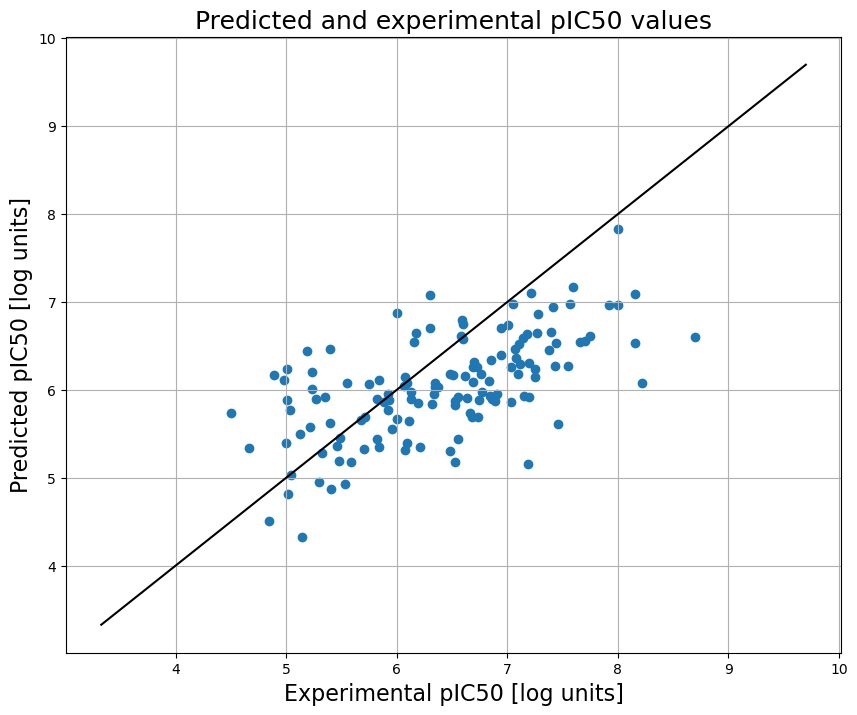

In [23]:
_, fig = plotScatterWithIdeal(df_actual_pred["experimental_value"].values, df_actual_pred["predicted_value"].values, title="Predicted and experimental pIC50 values", xtext="Experimental pIC50 [log units]", ytext="Predicted pIC50 [log units]")
fig.savefig("predictedvsexperimental.pdf", dpi=300)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
fig_scatter = px.scatter(df_actual_pred,
                     x='experimental_value',
                     y='predicted_value',
                     color='prediction_residue',
                     title='Androgen receptor, predicted vs. actual scatter plot',
                    #  labels={'y_true': 'Measured Solubility'},
                     width=1200,
                     height=800, 
                     range_x=(4, 9),
                     range_y=(4, 9)
                    #  size_max=50
                    #  marker=dict(size=12)
                     )
fig_scatter.update_traces(marker_size=10)
fig_scatter.update_layout(
    title=dict(text="Androgen receptor, predicted vs. actual scatter plot", font=dict(size=28), automargin=True, yref='paper'),
    xaxis_title=dict(text="Experimental pIC50 value (log units)", font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=20)), 
    yaxis_title=dict(text="Predicted pIC50 value (log units)", font=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20)),
    legend=dict(orientation='h')
)

In [6]:
fig_scatter.write_image("test_set_scatter.png")

<Axes: >

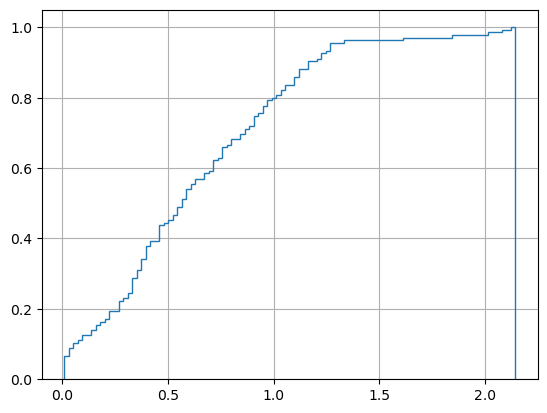

In [14]:
df_actual_pred["prediction_residue"].hist(bins=100, density=True, cumulative=True, histtype='step')

In [28]:
df_actual_pred["prediction_residue"].mean()

0.6411167429490976

In [10]:
t = 0.75
df_actual_pred[df_actual_pred["prediction_residue"] < t].shape[0] / df_actual_pred.shape[0] 

0.6296296296296297

In [16]:
fig_scatter

In [6]:
app_pca = molplotly.add_molecules(fig=fig_scatter,
                                  df=df_actual_pred.reset_index(),
                                  smiles_col='coms_canonical_smiles',
                                  title_col='index',
                                  caption_cols=['prediction_residue'],
                                #   caption_transform={'Measured Solubility': lambda x: f"{x:.2f}"},
                                  color_col='prediction_residue',
                                  show_coords=False)
app_pca.run_server(mode='inline', port=8707, height=850)

In [13]:
sms = df_actual_pred.loc[[331, 842, 1172, 298], "coms_canonical_smiles"].to_list()
sms

['CC(C)c1cc(=O)[nH]c2ccc(N(CC(F)(F)F)CC(F)(F)F)cc12',
 'CN1CCN(OC(=O)N[C@@H]2C[C@]3(C)O[C@]2(C)[C@@H]2C(=O)N(c4ccc(C#N)c(C(F)(F)F)c4)C(=O)[C@@H]23)CC1',
 'C[C@](O)(Cn1cc(Br)c(F)n1)C(=O)Nc1cnc(C#N)c(C(F)(F)F)c1',
 'CCN[C@H]1C[C@H](C)S(=O)(=O)c2sc(S(N)(=O)=O)cc21']

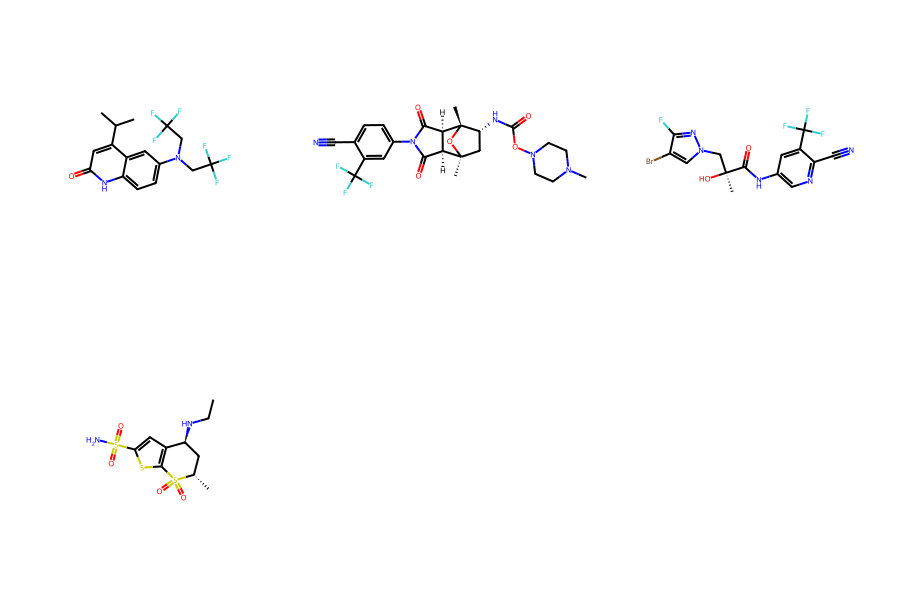

In [18]:
Draw.MolsToGridImage([Chem.MolFromSmiles(item) for item in sms], subImgSize=(300, 300))

# Classifier

In [2]:
with open(co.TRAINING_CONF_DIR/"ar_xgboost_classifier_pca50.json", "r") as f:
    training_params = json.load(f)

In [3]:
df_actual_pred_classifier = pd.read_csv("C:/Users/rbachorz/Projects/qsarmodeler/qsarmodeler/data/processed/ar/classifier_validation_actual_predicted.csv", index_col="Unnamed: 0")
df_actual_pred_classifier["experimental_value"] = df_actual_pred_classifier["experimental_value"].astype(int)
df_actual_pred_classifier

,coms_canonical_smiles,experimental_value,predicted_value
1637,CCc1cc2c(C(F)(F)F)cc(=O)[nH]c2cc1N,1,0.922289
649,N#Cc1ccc(SCC2CC2)cc1C(F)(F)F,1,0.988288
1658,CCOC(=O)C(CC)Oc1ccc2c(C)cc(=O)oc2c1,0,0.011701
544,C[C@@H](Nc1cc(C(F)(F)F)c(C#N)cn1)c1ccccc1,0,0.183066
1592,CC[C@@H]1CC2=CC(=O)CC[C@@H]2[C@H]2CC[C@@]3(CC)...,1,0.874896
...,...,...,...
1626,O=c1cc(C(F)(F)F)c2ccc(NC3CCC3)cc2[nH]1,1,0.944067
282,O=C1[C@@H]2C3C=CC(CCC3)[C@@H]2C(=O)N1c1ccc([N+...,1,0.847121
1194,Fc1ccc(C2=NOC3CCCCCC23)c(C(F)(F)F)c1,1,0.186525
1229,c1ccc(OCCCSc2nc3ccccc3[nH]2)cc1,0,0.002781


In [12]:
y_train = df_actual_pred_classifier["experimental_value"]
y_train_pred = df_actual_pred_classifier["predicted_value"]

pr = precision_score(y_train, y_train_pred > training_params["training_aux_data"]["threshold"])
re = recall_score(y_train, y_train_pred > training_params["training_aux_data"]["threshold"])
spe = recall_score(y_train, y_train_pred > training_params["training_aux_data"]["threshold"], pos_label=False)
acc = accuracy_score(y_train, y_train_pred > training_params["training_aux_data"]["threshold"])
f1 = f1_score(y_train, y_train_pred > training_params["training_aux_data"]["threshold"])
rocauc = roc_auc_score(y_train, y_train_pred > training_params["training_aux_data"]["threshold"])
ap = average_precision_score(y_train, y_train_pred > training_params["training_aux_data"]["threshold"])
mcc = matthews_corrcoef(y_train, y_train_pred > training_params["training_aux_data"]["threshold"])

In [13]:
logging.info("Accuracy on hold-out: %f", np.round(acc*100, 1))
logging.info("Precision on hold-out: %f", np.round(pr*100, 1))
logging.info("Recall/Sensitivity on hold-out: %f", np.round(re*100, 1))
logging.info("Specificity on hold-out: %f", np.round(spe*100, 1))
logging.info("F1-score on hold-out: %f", np.round(f1*100, 1))
logging.info("ROC-AUC on hold-out: %f", np.round(rocauc*100, 1))
logging.info("Average precision on hold-out: %f", np.round(ap*100, 1))
logging.info("MCC on hold-out: %f", np.round(mcc*100, 1))

INFO:Accuracy on hold-out: 82.000000
INFO:Precision on hold-out: 85.400000
INFO:Recall/Sensitivity on hold-out: 85.400000
INFO:Specificity on hold-out: 76.400000
INFO:F1-score on hold-out: 85.400000
INFO:ROC-AUC on hold-out: 80.900000
INFO:Average precision on hold-out: 82.000000
INFO:MCC on hold-out: 61.800000


In [16]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

DEBUG:Assigning font /F1 = 'C:\\Users\\rbachorz\\AppData\\Local\\miniconda3\\envs\\chemspace\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'


DEBUG:Embedding font C:\Users\rbachorz\AppData\Local\miniconda3\envs\chemspace\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
DEBUG:Writing TrueType font.


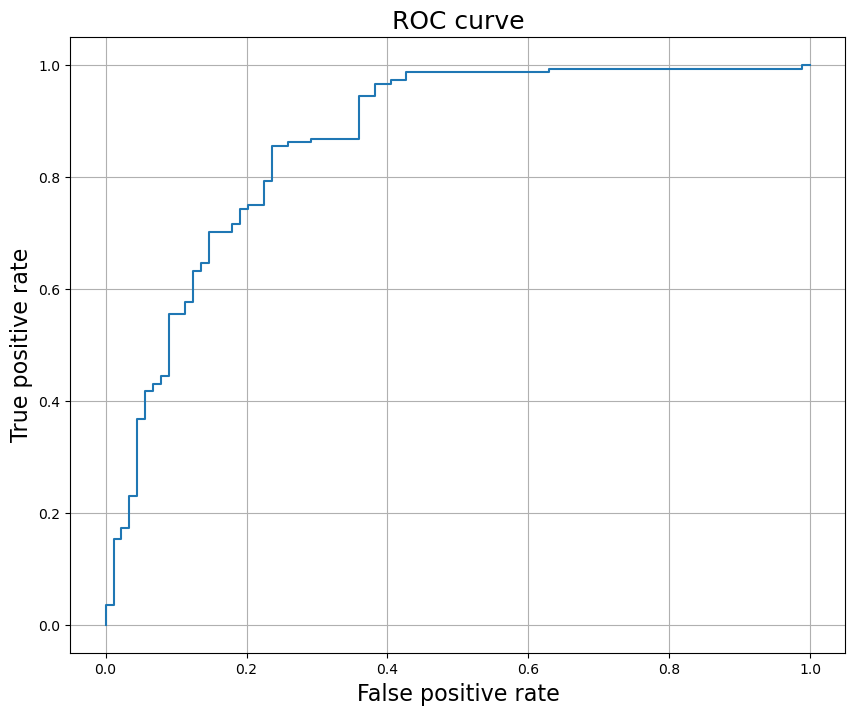

In [28]:
def roc_plot(x, y, title, confidence=None, xtext="Actual", ytext="Predicted", ideal=True):
    fig, ax = plt.subplots(figsize=(10, 8), facecolor="white")
    plt.plot(x, y)
    p1 = max(max(y), max(x)) + 1.0
    p2 = min(min(y), min(x)) - 1.0
    if ideal:
        plt.plot([p1, p2], [p1, p2], 'k-')
    plt.grid()
    ax.set_title(title, fontsize=18)
    ax = plt.gca()
    ax.set_xlabel(xtext, fontsize=16)
    ax.set_ylabel(ytext, fontsize=16)
    return ax, fig
_, fig = roc_plot(fpr, tpr, title="ROC curve", xtext="False positive rate", ytext="True positive rate", ideal=False)
fig.savefig("roccurve.pdf", dpi=300)